# Лабораторна робота №2 — EDA та Навчання з вчителем (Supervised Learning)

## Мета
Навчитись робити розвідку даних (Exploratory Data Analysis - EDA) та використовувати інструменти для моделювання при навчанні з вчителем.

## Завдання
1. Завантажити дані `home-credit-default-risk` через `kagglehub`.
2. Провести EDA (огляд даних, пропуски, баланс класів).
3. Підготувати дані (обробка пропусків, кодування категоріальних ознак).
4. Побудувати класифікатор та оцінити його якість (ROC AUC).
5. Зробити передбачення для тестового набору та створити файл сабмішну.

### Імпорти

In [1]:
import os
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


plt.style.use("ggplot")
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

SEED = 42
np.random.seed(SEED)

### Завантаження датасету
Завантаження даних для виконання лабораторної роботи.

In [2]:
DATASET = "home-credit-default-risk"

try:
    download_dir = Path(kagglehub.competition_download(DATASET))
    print(f"Downloaded to: {download_dir}")
except Exception as e:
    print("Error downloading dataset. Ensure you have ~/.kaggle/kaggle.json or env vars set.")
    raise e

for file in download_dir.iterdir():
    print(file.name)

train_path = download_dir / "application_train.csv"
test_path = download_dir / "application_test.csv"

if not train_path.exists():
    print("WARNING: application_train.csv not found directly in download dir. Check file structure.")

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Downloaded to: /home/dmutro/.cache/kagglehub/competitions/home-credit-default-risk
application_test.csv
application_train.csv
previous_application.csv
bureau_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
POS_CASH_balance.csv
sample_submission.csv
credit_card_balance.csv
bureau.csv
Train shape: (307511, 122)
Test shape: (48744, 121)


### EDA (Розвідувальний аналіз даних)

In [3]:
# Перші 5 рядків тренувального набору
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

#### Перевірка балансу цільової змінної (`TARGET`)

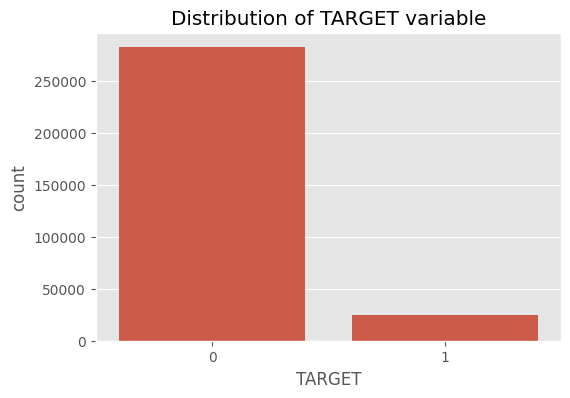

Class balance:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x="TARGET", data=df_train)
plt.title("Distribution of TARGET variable")
plt.show()

target_counts = df_train["TARGET"].value_counts(normalize=True)
print("Class balance:")
print(target_counts)

#### Аналіз пропущених значень

In [5]:
missing_values = df_train.isnull().sum().sort_values(ascending=False)
missing_percent = (df_train.isnull().sum() / df_train.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([missing_values, missing_percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


### Підготовка даних (Preprocessing)
Для спрощення лабораторної роботи візьмемо лише числові колонки та виконаємо просту імп'ютацію (заповнення пропусків) та масштабування. Для категоріальних змінних можна використати One-Hot Encoding, але для початку спробуємо базовий підхід.

In [6]:
y = df_train["TARGET"]
X = df_train.drop(columns=["TARGET", "SK_ID_CURR"])
X_test = df_test.drop(columns=["SK_ID_CURR"])

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
)
н)
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=SEED, solver='lbfgs', C=0.1))
])


Numeric features: 104
Categorical features: 16


### Розбиття на Train/Validation

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(f"Train size: {X_train.shape}, Val size: {X_val.shape}")

Train size: (246008, 120), Val size: (61503, 120)


### Навчання моделі та оцінка якості

In [8]:
model_pipeline.fit(X_train, y_train)

y_val_pred_proba = model_pipeline.predict_proba(X_val)[:, 1]

auc_score = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC: {auc_score:.4f}")

Validation ROC AUC: 0.7471


### Візуалізація важливості ознак (для Логістичної регресії)

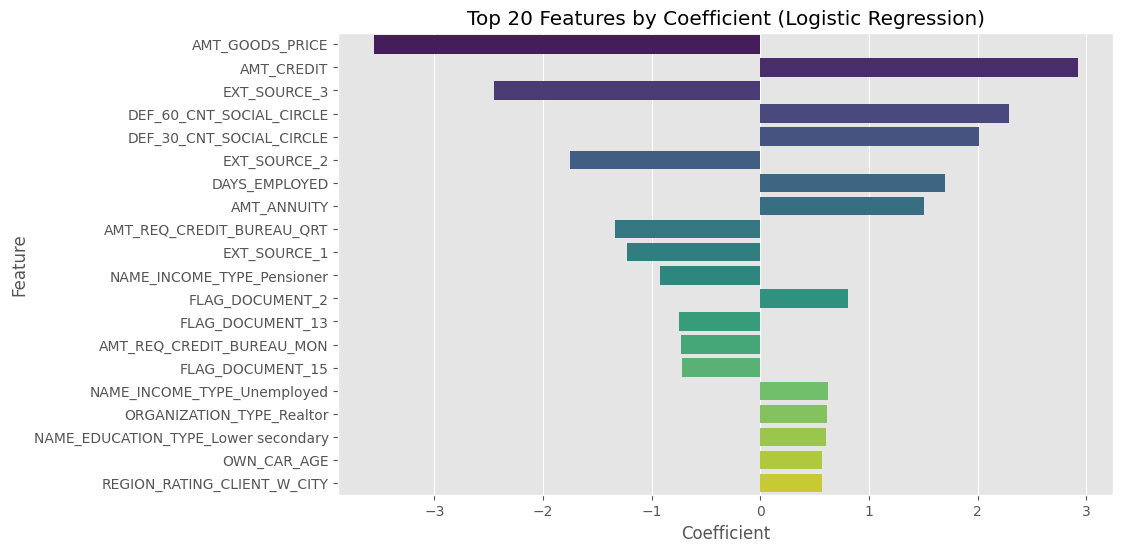

In [9]:
try:
    feature_names = model_pipeline.named_steps["preprocessor"].get_feature_names_out()
    coefs = model_pipeline.named_steps["classifier"].coef_[0]

    feature_importance = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs})
    feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
    feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Coefficient", y="Feature",  data=feature_importance, hue="Feature", legend=False, palette="viridis")
    plt.title("Top 20 Features by Coefficient (Logistic Regression)")
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

### Побудова Submission файлу

In [10]:
test_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "SK_ID_CURR": df_test["SK_ID_CURR"],
    "TARGET": test_pred_proba
})

submission.head()

,SK_ID_CURR,TARGET
0,100001,0.384144
1,100005,0.787604
2,100013,0.351224
3,100028,0.343657
4,100038,0.645146


In [11]:
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")

Submission saved to submission.csv
